In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import time
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

### 1 Read in the cleaned data data

In [57]:
df=pd.read_csv("cleaned_df.csv", index_col=False)


In [58]:
df.head()

,Place,Num,Name,Ag,Hometown,gender,div,gun_s,net_s,pace_s
0,1,9,Joshua Kemei,22.0,Kenya .,M,20-29,28.800000,28.783333,4.633333
1,2,35,George Kirwa Misoi,22.0,Kenya .,M,20-29,29.183333,29.166667,4.700000
2,3,3,Jacob Frey,24.0,Oakton VA,M,20-29,29.633333,29.616667,4.766667
3,4,49,Gurmessa Kumsa,27.0,Oxon Hill MD,M,20-29,29.766667,29.766667,4.800000
4,5,31,Mike Baird,24.0,Ardmore PA,M,20-29,30.516667,30.500000,4.916667


In [59]:
# get cleaned data by gender
df_f = df.loc[df.gender=='F',:].copy()
df_m = df.loc[df.gender=='M',:].copy()

## 2 Create new variable

In [60]:
# Add column that shows the time to cross the start line after starter pistol fires
df['cross_t'] = df.loc[:,'gun_s'] - df.loc[:,'net_s']
df['cross_t'].describe()

count    2366.000000
mean        2.851451
std         1.583923
min         0.000000
25%         1.266667
50%         3.266667
75%         3.833333
max         9.333333
Name: cross_t, dtype: float64

## 3 Explore across the columns

### 3.1 side by side boxplots

In [61]:
fig = px.box(df, y='gun_s', x='gender',  color="gender", points="all",
             notched=False, # used notched shape
             title="Box plot of net time",

            )
fig.update_xaxes(title="Gender")
fig.update_yaxes(title="Net time (minutes)")
fig.update_traces(orientation='v') # horizontal box plots
fig.show()

In [62]:
fig = px.box(df, y='pace_s', x='gender',  color="gender", points="all",
             notched=False, # used notched shape
             title="Box plot of pace",

            )
fig.update_xaxes(title="Gender")
fig.update_yaxes(title="Pace")
fig.update_traces(orientation='v') # horizontal box plots
fig.show()

### 3.2 Analyze the difference between gun and net time race results

Text(0, 0.5, 'Density')

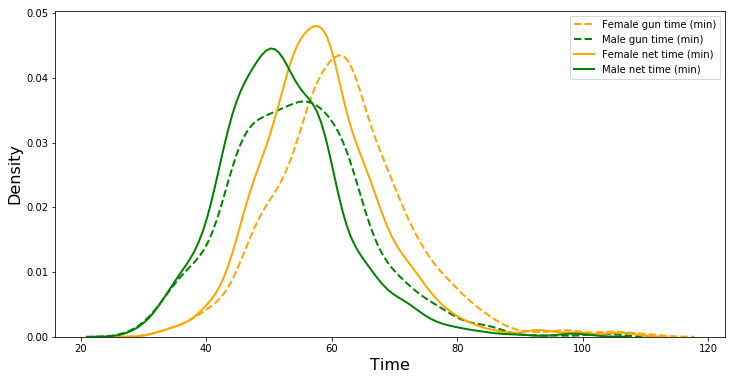

In [63]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df_f.loc[:,'gun_s'], color='orange', linestyle='--',label='Female gun time (min)', linewidth=2)
sns.kdeplot(df_m.loc[:,'gun_s'], label='Male gun time (min)', linestyle='--', color='green',linewidth=2)
sns.kdeplot(df_f.loc[:,'net_s'], color='orange',label='Female net time (min)', linewidth=2)
sns.kdeplot(df_m.loc[:,'net_s'], label='Male net time (min)', color='green',linewidth=2)
plt.legend(loc=1, prop={'size': 10})
plt.xlabel('Time', fontsize=16);plt.ylabel('Density', fontsize=16)

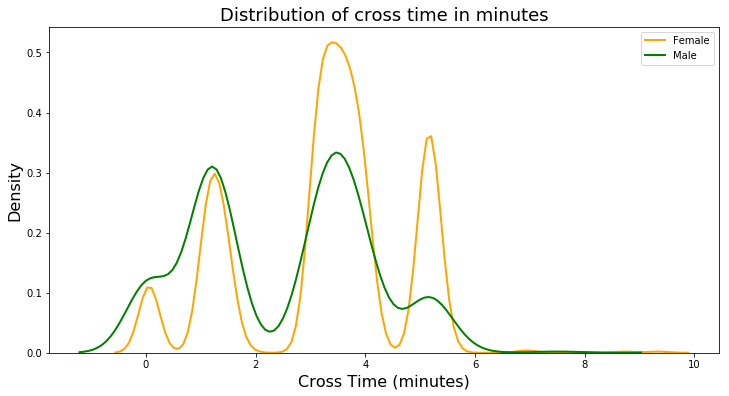

In [64]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df.loc[df.gender=='F','cross_t'], label='Female', color='orange',linewidth=2)
sns.kdeplot(df.loc[df.gender=='M','cross_t'], label='Male', color='green',linewidth=2)
# plot
plt.xlabel('Cross Time (minutes)', fontsize=16);plt.ylabel('Density', fontsize=16); 
plt.title('Distribution of cross time in minutes', fontsize=18)

plt.legend(loc=1, prop={'size': 10})

In [65]:
# percentage of racer with cross time less than 2.2 min
# female
print(df.loc[(df.gender=='F') & (df.cross_t>2.2),].shape[0]/df.loc[df.gender=='F','cross_t'].shape[0] *100)
# male
df.loc[(df.gender=='M') & (df.cross_t>2.2),].shape[0]/df.loc[df.gender=='M','cross_t'].shape[0] *100

75.7026291931097


54.71100554235946

In [66]:

fig = px.scatter(df, x="cross_t", y="net_s", color='gender',opacity=0.5)
fig.update_xaxes(title="Cross Time (minutes)")
fig.update_yaxes(title="Net Time (minutes)")

fig.show()

### 3.3 How much time separates Chris Doe from the top 10 percentile of racers of the samedivision?

In [67]:
# find Chris Doe
doe = df_m.loc[df_m.Name=="Chris Doe",:]
doe 

,Place,Num,Name,Ag,Hometown,gender,div,gun_s,net_s,pace_s
533,535,2869,Chris Doe,44.0,Reson VA,M,40-49,53.116667,49.716667,8.0


In [68]:
# chris's rank
stats.percentileofscore(df_m.net_s, np.sum(df_m.loc[df_m.Name=="Chris Doe",'net_s']))

42.280285035629454

Chris Doe has an age of 44, so we will find people in his division (male with age between 40-49)

In [69]:
df_cd = df_m.loc[(df_m.Ag >=40) & (df_m.Ag <50),: ]
df_cd.shape

(415, 10)

among his division, find the top 10 percentile of racers, here we can define the top racers use net time


In [70]:
# find the net time for 10 percentile
perc = np.percentile(df_cd.net_s, 10)
perc

41.69

In [71]:
# subset the data to the 10% racers
df_top = df_cd.loc[df_cd.net_s<=perc,:]
df_top.shape

(42, 10)

How much time does Chris needs to save if he wants to be included in the group of top 10 percentile of racers?

In [72]:
s1  = doe.net_s - perc
s1

533    8.026667
Name: net_s, dtype: float64

what is the net time difference between Chris's and the mean of the top group

In [73]:
s2 = doe.net_s - np.mean(df_top.net_s)
s2

533    11.582937
Name: net_s, dtype: float64

we can visualize the results

In [74]:
fig = px.histogram(df_cd, x="net_s")
dt = df_m.loc[df_m.Name=="Chris Doe",'net_s']
fig.add_vline(x=np.sum(dt), line_width=3, line_dash="dash", line_color="brown")
fig.add_vline(x=perc, line_width=3, line_dash="dash", line_color="yellow")
fig.add_vline(x=np.sum(np.mean(df_top.net_s)), line_width=3, line_dash="dash", line_color="red")
fig.update_yaxes(title="Count of racers")
fig.update_xaxes(title="Net time (minutes)")
fig.show()



### 3.4 Compare the race results of each division.

In [75]:
fig = px.histogram(df, x="div", color="gender", 
                         hover_data=df.columns,opacity=0.8)
fig.update_xaxes(title="Division")
fig.update_xaxes(categoryorder='array', categoryarray= ['0-14','15-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89'])

fig.update_yaxes(title="Count of Racers")
fig.update_layout(barmode='group')
fig.show()

In [76]:
# ratio of racers ageing between 30-49
df.loc[(df.Ag>29)&(df.Ag<50),:].shape[0]/df.shape[0]

0.6187658495350803

In [77]:
fig = px.box(df, x="div", y="net_s", color="gender")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.update_xaxes(categoryorder='array', categoryarray= ['0-14','15-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89'])
fig.update_xaxes(title="Division")
fig.update_yaxes(title="Net time (minutes)")
fig.show()

In [78]:
fig = px.box(df, x="div", y="pace_s", color="gender")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.update_xaxes(categoryorder='array', categoryarray= ['0-14','15-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89'])
fig.update_xaxes(title="Division")
fig.update_yaxes(title="Pace (minutes)")
fig.show()

In [79]:
stat1 = df.pivot_table(values="net_s",index="div",columns="gender").round(2)
stat1

gender,F,M
div,,
0-14,58.89,55.56
15-19,52.13,46.65
20-29,57.25,49.52
30-39,58.70,51.66
40-49,57.87,51.61
50-59,62.59,53.93
60-69,60.01,58.47
70-79,64.11,59.26
80-89,NaN,73.66


In [80]:
stat2 = df.pivot_table(values="pace_s",index="div",columns="gender").round(2)
stat2

gender,F,M
div,,
0-14,9.48,8.95
15-19,8.40,7.52
20-29,9.22,7.98
30-39,9.45,8.32
40-49,9.32,8.31
50-59,10.08,8.69
60-69,9.66,9.42
70-79,10.33,9.54
80-89,NaN,11.87


In [81]:
# df.div.unique
df.loc[:,'div'].unique()

array(['20-29', '30-39', '15-19', '40-49', '50-59', '60-69', '0-14',
       '70-79', '80-89'], dtype=object)

In [82]:
# get ANOVA table as R like output
# drop div 80-89 because only male group has racer in this range
df1 = df.copy().loc[df.loc[:,'div']!='80-89',:]
# Ordinary Least Squares (OLS) model
model = ols('net_s ~ C(div) + C(gender)+ C(div):C(gender)', data=df1).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table.round(2)

,sum_sq,df,F,PR(>F)
C(div),9215.22,7.0,14.35,0.00
C(gender),26244.12,1.0,286.08,0.00
C(div):C(gender),1010.48,7.0,1.57,0.14
Residual,215401.83,2348.0,NaN,NaN


In [83]:
df_mean = df.groupby(["gender","div"],as_index=False).agg({"net_s":"mean"}).sort_values(["gender","div"],ascending=[False,True])
df_mean

,gender,div,net_s
8,M,0-14,55.557738
9,M,15-19,46.654444
10,M,20-29,49.522454
11,M,30-39,51.655202
12,M,40-49,51.605020
13,M,50-59,53.925772
14,M,60-69,58.472464
15,M,70-79,59.259259
16,M,80-89,73.658333
0,F,0-14,58.887500


In [84]:
px.line(df_mean,x="div",y="net_s",color="gender").update_xaxes(title="Divisions").update_yaxes(title="Net time (minutes)")